In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle

print("Loading train.tsv - GoEmotions dataset (Reddit emotions)...")
df = pd.read_csv('train.tsv', sep='\t', header=None, names=['text', 'label_ids', 'id'])

print(f"Total samples: {len(df):,}")

# GoEmotions 28 emotion labels mapping to 6 basic emotions
# Based on official GoEmotions taxonomy
emotion_mapping = {
    # Joy (12 emotions)
    '17': 'joy',    # joy
    '1': 'joy',     # amusement
    '4': 'joy',     # approval
    '13': 'joy',    # excitement
    '15': 'joy',    # gratitude
    '18': 'joy',    # love
    '20': 'joy',    # optimism
    '23': 'joy',    # relief
    '21': 'joy',    # pride
    '0': 'joy',     # admiration
    '8': 'joy',     # desire
    '5': 'joy',     # caring
    
    # Sadness (5 emotions)
    '25': 'sadness',   # sadness
    '9': 'sadness',    # disappointment
    '12': 'sadness',   # embarrassment
    '16': 'sadness',   # grief
    '24': 'sadness',   # remorse
    
    # Anger (3 emotions)
    '2': 'anger',      # anger
    '3': 'anger',      # annoyance
    '10': 'anger',     # disapproval
    
    # Fear (2 emotions)
    '14': 'fear',      # fear
    '19': 'fear',      # nervousness
    
    # Surprise (4 emotions)
    '26': 'surprise',  # surprise
    '22': 'surprise',  # realization
    '6': 'surprise',   # confusion
    '7': 'surprise',   # curiosity
    
    # Disgust (1 emotion)
    '11': 'disgust',   # disgust
    
    # Skip neutral (27) for cleaner emotion detection
}

# Keep only single-label samples for cleaner training
df_single = df[~df['label_ids'].astype(str).str.contains(',')].copy()
print(f"\nSingle-label samples: {len(df_single):,}")

# Map to 6 emotions
df_single['emotion'] = df_single['label_ids'].map(emotion_mapping)

# Remove unmapped labels
df_single = df_single.dropna(subset=['emotion'])

print(f"\nMapped samples: {len(df_single):,}")
print("\nEmotion distribution:")
print(df_single['emotion'].value_counts())


Loading train.tsv - GoEmotions dataset (Reddit emotions)...
Total samples: 43,410

Single-label samples: 36,308

Mapped samples: 23,485

Emotion distribution:
emotion
joy         12920
anger        3878
surprise     3553
sadness      2121
fear          515
disgust       498
Name: count, dtype: int64
Loading train.tsv - GoEmotions dataset (Reddit emotions)...
Total samples: 43,410

Single-label samples: 36,308

Mapped samples: 23,485

Emotion distribution:
emotion
joy         12920
anger        3878
surprise     3553
sadness      2121
fear          515
disgust       498
Name: count, dtype: int64


In [7]:
# Balance emotions - use minimum count
min_count = df_single['emotion'].value_counts().min()
print(f"\nMinimum count: {min_count:,}")

# Use all available samples from smallest class
target_size = min_count

balanced_dfs = []
for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust']:
    df_emotion = df_single[df_single['emotion'] == emotion]
    if len(df_emotion) >= target_size:
        df_emotion_sample = df_emotion.sample(n=target_size, random_state=42)
    else:
        # If not enough samples, use what we have
        df_emotion_sample = df_emotion
    balanced_dfs.append(df_emotion_sample)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset: {len(df_balanced):,} samples")
print("\nBalanced distribution:")
print(df_balanced['emotion'].value_counts().sort_index())


Minimum count: 498

Balanced dataset: 2,988 samples

Balanced distribution:
emotion
anger       498
disgust     498
fear        498
joy         498
sadness     498
surprise    498
Name: count, dtype: int64


In [8]:
# Map emotions to IDs
label2id = {"anger": 0, "disgust": 1, "fear": 2, "joy": 3, "sadness": 4, "surprise": 5}
id2label = {0: "anger", 1: "disgust", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise"}

df_balanced["label"] = df_balanced["emotion"].map(label2id)

print("Emotions mapped successfully!")
print(f"\nLabel mapping: {label2id}")

Emotions mapped successfully!

Label mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [9]:
# Split data
train_df, test_df = train_test_split(
    df_balanced[['text', 'label']], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("\n✅ Datasets prepared for BERT training")

Training samples: 2,390
Test samples: 598

✅ Datasets prepared for BERT training


In [10]:
# Load BERT tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Tokenize datasets
print("Tokenizing training data...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
print("Tokenizing test data...")
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print(f"\n✅ Tokenization complete!")
print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")

Loading BERT tokenizer...
Tokenizing training data...
Tokenizing training data...


Map:   0%|          | 0/2390 [00:00<?, ? examples/s]

Tokenizing test data...


Map:   0%|          | 0/598 [00:00<?, ? examples/s]


✅ Tokenization complete!
Training samples: 2,390
Test samples: 598


In [12]:
# Load BERT model for 6-class emotion classification
print("Loading BERT model for emotion classification...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training arguments
training_args = TrainingArguments(
    output_dir='./emotion_bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',  # Updated parameter name
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    push_to_hub=False,
)

# Metric function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("\n✅ BERT Trainer initialized!")
print("Ready to train...")

Loading BERT model for emotion classification...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu

✅ BERT Trainer initialized!
Ready to train...

✅ BERT Trainer initialized!
Ready to train...


In [13]:
# Train the model
print("\n🚀 Starting BERT training...")
print("This will take approximately 15-30 minutes...")
print("=" * 60)

trainer.train()

print("\n✅ Training completed!")
print("\nEvaluating on test set...")
results = trainer.evaluate()

print("\n📊 Emotion Detection Model Performance")
print("=" * 60)
print(f"Accuracy:  {results['eval_accuracy']:.4f}")
print(f"F1-score:  {results['eval_f1']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall:    {results['eval_recall']:.4f}")


🚀 Starting BERT training...
This will take approximately 15-30 minutes...


c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.171400,0.954938,0.673913,0.667688,0.704231,0.673913
2,0.719400,0.836645,0.712375,0.715734,0.724523,0.712375
3,0.331600,0.842899,0.727425,0.727986,0.732443,0.727425


c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Training completed!

Evaluating on test set...


c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Emotion Detection Model Performance
Accuracy:  0.7274
F1-score:  0.7280
Precision: 0.7324
Recall:    0.7274



📋 Detailed Classification Report:


c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       anger     0.5652    0.6566    0.6075        99
     disgust     0.7470    0.6263    0.6813        99
        fear     0.8302    0.8800    0.8544       100
         joy     0.8000    0.7200    0.7579       100
     sadness     0.7129    0.7200    0.7164       100
    surprise     0.7379    0.7600    0.7488       100

    accuracy                         0.7274       598
   macro avg     0.7322    0.7271    0.7277       598
weighted avg     0.7324    0.7274    0.7280       598



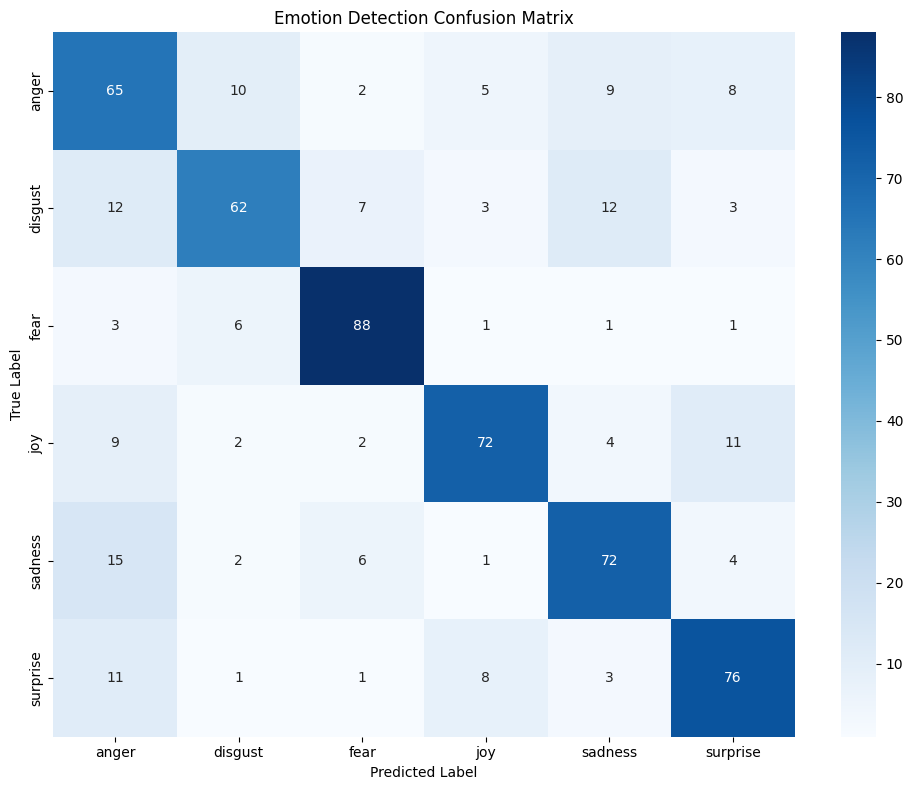


✅ Evaluation complete!


In [14]:
# Detailed classification report
from sklearn.metrics import classification_report

print("\n📋 Detailed Classification Report:")
print("=" * 60)

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Print detailed report
print(classification_report(
    y_true, y_pred, 
    target_names=list(label2id.keys()),
    digits=4
))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label2id.keys()), 
            yticklabels=list(label2id.keys()))
plt.title('Emotion Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")

In [15]:
# Test emotion prediction function
def predict_emotion(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_id = torch.argmax(probs, dim=-1).item()
    
    return {
        'emotion': id2label[pred_id],
        'confidence': float(probs[0][pred_id]),
        'probabilities': {id2label[i]: float(probs[0][i]) for i in range(6)}
    }

# Test examples
test_texts = [
    "I'm so happy and excited about this!",
    "This makes me really sad and disappointed.",
    "I'm absolutely furious about what happened!",
    "That's terrifying! I'm so scared.",
    "Wow! I didn't expect that at all!",
    "This is disgusting and revolting."
]

emotion_emoji = {
    'joy': '😊',
    'sadness': '😢',
    'anger': '😠',
    'fear': '😨',
    'surprise': '😮',
    'disgust': '🤢'
}

print("🔮 Testing BERT Emotion Detection:\n")
print("=" * 70)
for text in test_texts:
    result = predict_emotion(text)
    emotion = result['emotion']
    print(f"\nText: {text}")
    print(f"Emotion: {emotion_emoji[emotion]} {emotion.upper()} ({result['confidence']:.1%})")
    print(f"All probabilities:")
    for emo, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {emotion_emoji[emo]} {emo}: {prob:.1%}")
    print("-" * 70)

🔮 Testing BERT Emotion Detection:


Text: I'm so happy and excited about this!
Emotion: 😊 JOY (96.2%)
All probabilities:
  😊 joy: 96.2%
  😮 surprise: 2.1%
  😢 sadness: 0.6%
  😨 fear: 0.5%
  😠 anger: 0.4%
  🤢 disgust: 0.3%
----------------------------------------------------------------------

Text: This makes me really sad and disappointed.
Emotion: 😢 SADNESS (96.9%)
All probabilities:
  😢 sadness: 96.9%
  😨 fear: 1.0%
  😊 joy: 0.8%
  🤢 disgust: 0.5%
  😠 anger: 0.5%
  😮 surprise: 0.3%
----------------------------------------------------------------------

Text: I'm absolutely furious about what happened!
Emotion: 😨 FEAR (68.1%)
All probabilities:
  😨 fear: 68.1%
  😠 anger: 12.5%
  🤢 disgust: 8.9%
  😢 sadness: 6.3%
  😮 surprise: 3.1%
  😊 joy: 1.1%
----------------------------------------------------------------------

Text: That's terrifying! I'm so scared.
Emotion: 😨 FEAR (97.6%)
All probabilities:
  😨 fear: 97.6%
  🤢 disgust: 0.8%
  😮 surprise: 0.5%
  😢 sadness: 0.5%
  😊 joy: 0.4%
  😠

In [17]:
# Save the trained BERT model
print("Saving BERT emotion model...")

# Save the model and tokenizer
model.save_pretrained('./emotion_bert_model')
tokenizer.save_pretrained('./emotion_bert_model')

# Save label mappings
with open('emotion_mappings.pkl', 'wb') as f:
    pickle.dump({'label2id': label2id, 'id2label': id2label}, f)

print("\n✅ Emotion Detection Model saved successfully!")
print("   - ./emotion_bert_model/ (BERT model + tokenizer)")
print("   - emotion_mappings.pkl (label mappings)")
print("\n🎉 BERT model is now ready to use in the app!")
print("\nTo load the model later:")
print("  from transformers import BertTokenizer, BertForSequenceClassification")
print("  model = BertForSequenceClassification.from_pretrained('./emotion_bert_model')")
print("  tokenizer = BertTokenizer.from_pretrained('./emotion_bert_model')")

Saving BERT emotion model...

✅ Emotion Detection Model saved successfully!
   - ./emotion_bert_model/ (BERT model + tokenizer)
   - emotion_mappings.pkl (label mappings)

🎉 BERT model is now ready to use in the app!

To load the model later:
  from transformers import BertTokenizer, BertForSequenceClassification
  model = BertForSequenceClassification.from_pretrained('./emotion_bert_model')
  tokenizer = BertTokenizer.from_pretrained('./emotion_bert_model')

✅ Emotion Detection Model saved successfully!
   - ./emotion_bert_model/ (BERT model + tokenizer)
   - emotion_mappings.pkl (label mappings)

🎉 BERT model is now ready to use in the app!

To load the model later:
  from transformers import BertTokenizer, BertForSequenceClassification
  model = BertForSequenceClassification.from_pretrained('./emotion_bert_model')
  tokenizer = BertTokenizer.from_pretrained('./emotion_bert_model')
